In [1]:
from dotenv import load_dotenv
import os
from pathlib import Path
load_dotenv()
spotify_client_id = os.getenv("SPOTIFY_CLIENT_ID")
spotify_client_secret = os.getenv("SPOTIFY_CLIENT_SECRET")
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(spotify_client_id, spotify_client_secret))

In [162]:
def tracks(track):
    tracks_data = {}
    audio_features_data = spotify.audio_features(track['id'])[0]
    audio_features = {key: audio_features_data[key] for key in ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']}
    tracks_data.update(audio_features)
    album_data = {key: track['album'][key] for key in ['release_date']}
    artists_data = {"artists": [artist['name'] for artist in track['artists']]}
    other_data = {key: track[key] for key in ['popularity', 'explicit', 'id', 'name']} 
    tracks_data.update(other_data)
    tracks_data.update(album_data)
    tracks_data.update(artists_data)
    return tracks_data
def dataframe(tracks_artist):
    tracks_data_list = []
    for track in tracks_artist['tracks']:
        tracks_data = tracks(track)
        tracks_data_list.append(tracks_data)
    return pd.DataFrame(tracks_data_list)
def series(tracks_data):
    return pd.DataFrame(tracks_data)
def normalize(df):    
    df["popularity"] = df["popularity"]/100
    df["tempo"] = df["tempo"].apply(lambda x: round(x/20))
    df["loudness"] = df["loudness"].apply(lambda x: round((x+60)/10))
    df["loudness"][df["loudness"]<0] == 0
    df["duration_ms"] = df["duration_ms"].apply(lambda x: round(x/60000))
    df = df.rename(columns = {"duration_ms": "duration_min"})
    return df
def save_file(df):    
        if(not(os.path.exists("tracks_df.csv"))):
            Path("tracks_df.csv").touch()
        if(os.path.getsize("tracks_df.csv") != 0):
            existing_df = pd.read_csv("tracks_df.csv")
            existing_df = existing_df.append(df, ignore_index=True)
            existing_df.drop_duplicates(subset = "id", keep = "last", inplace = True)
            existing_df.to_csv("tracks_df.csv", mode = "w", index = None)
            return existing_df
        else:
            df.to_csv("tracks_df.csv", mode = "w", index = None)
            return df
def auto_save(artist_list):
    for artist_id in artist_list:
        df = spotify.artist_top_tracks(artist_id)
        df = dataframe(df)
        df = normalize(df)
        df = save_file(df)
        return df

In [128]:
import pandas as pd
import numpy as np
import re
import ast
def search_artist(string = "--"):
    results = spotify.search(q='artist:'+string, type='artist')
    items = results['artists']['items']
    if len(items) > 0:
        artist = items[0]
        df_artist = pd.Series(artist)
        df_artist = df_artist[df_artist.index.isin(['name', 'followers', 'genres', 'id', 'popularity'])]
        df_artist["followers"] = df_artist["followers"]['total']
        return df_artist
def col(df, colname = "artist_name"):
    return np.array([int(x == colname) for x in df.columns]).argmax()
def query_track(df, string = "--", full = True):
    for i, track in enumerate(df["name"]):
        if(len(re.findall("(.*?)"+string+"(.*?)", "".join(track))) != 0):
            if(full):
                print(df.iloc[i], "\n")
            else:
                print("Name: ", df.iloc[i, col(df, "track_name")], "\nId: ", df.iloc[i, col(df, "track_id")],
                    "\nArtist: ", df.iloc[i, col(df)])

def show_corr(df, thr = 0.5):
    return ((pd.DataFrame(df.corr())[pd.DataFrame(abs(df.corr())) > thr].notnull()*1).sum().sum() - len(pd.DataFrame(df.corr()).index))/2
def threshold_corr(df, thr = 0.5):
    corr_matrix = pd.DataFrame(df.corr().fillna(0))
    corr_pos = corr_matrix[corr_matrix > thr].notnull()
    corr_neg = corr_matrix[corr_matrix < -thr].notnull()
    columns = indexes = corr_pos.columns
    for row in range(len(indexes)):
        for col in range(len(columns)):
            if(row <= col):
                pass
            elif(corr_pos.iloc[row, col] == True):
                print(indexes[row], " <-> ", columns[col], "(", corr_matrix.iloc[row, col], ")")
            elif(corr_neg.iloc[row, col] == True):
                print(indexes[row], " <-> ", columns[col], "(", corr_matrix.iloc[row, col], ")")
def find_genres(df):
    genres = []
    names = df["artists"]
    for name in names:
        try:
            genres.append(search_artist(name)["genres"])
        except:
            genres.append([])
    series = pd.Series(genres, name = "genres")
    series_genre = dd.from_pandas(series, npartitions = 5)
    df = dd.concat([df, series_genre], axis = 1)
    return df
def perfect_eval(string):
    try:
        return ast.literal_eval(string)
    except:
        return []
def bygenre(df):
    lists = []
    ids = []
    col = np.array([int(x == "genres") for x in df.columns]).argmax()
    for i, ser in enumerate(df["genres"]):
        strlist = perfect_eval(ser)
        if(len(strlist) > 1):
            ids.append(i)
        for genre in strlist:
            df = df.copy()
            df.iloc[i, col] = genre
            lists.append(df.iloc[i])
    dfs = pd.DataFrame(lists)
    df = df.append(dfs)
    df = df.groupby('genres').agg(agg)
    return df
def top_features(df):
    dictall = {}
    for ft in ["acousticness", "danceability", "duration_ms", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "tempo", "valence", "popularity"]:
        dictfts = []
        dfs = df.sort_values(by = ft, ascending = False).iloc[:5][["genres", ft]].set_index("genres")
        for i in range(len(dfs.index)):
            dictft = {}
            dictft.update({dfs.index[i]: dfs.iloc[i][ft]})
            dictfts.append(dictft)
        dictall.update({ft: dictfts})
    return dictall
bymean = ("acousticness", "danceability", "duration_ms", "energy", "instrumentalness",
           "liveness", "loudness", "speechiness", "tempo", "valence", "popularity")
bymode = ("key", "mode")
agg = {}
for ft in bymean:
    agg.update({ft: np.mean})
for ft in bymode:
    agg.update({ft: lambda x: x.value_counts().index[0]})
import re
def find_year(date):
    strdate = " ".join(date)
    years = re.findall("[0-9]{4}", strdate)
    return pd.Series(years).value_counts()

In [120]:
from math import ceil
def retrieve(early, late=2020, count=100, shift=0, exclude=[]):
    def find_end(date):
        strdate = " ".join(date)
        years = re.findall("[0-9]{4}", strdate)
        vals = pd.Series(years).value_counts()
        return vals[vals != 100]
    packages = []
    limit = 50
    offset = ceil(count/limit)
    modulo = count%limit
    print("Step 1: Ready")
    for x in range(early, late+1):
        if(np.sum([(1 if x==y else 0) for y in exclude]) == 1):
            print("Exclude: ", str(x))
        else:
            package = []
            for i in range(offset):
                if(i == offset-1 and modulo > 0): 
                    pack = spotify.search(q="year:"+str(x), type = "track", limit = modulo, offset = i*limit+shift)
                else:
                    pack = spotify.search(q="year:"+str(x), type = "track", limit = limit, offset = i*limit+shift)
                for j in pack["tracks"]["items"]:
                    package.append(j)
        packages.extend(package)
    print("Step 1: Done")
    package_ = []
    limit_ = 100
    offset_ = ceil(len(packages)/limit_)
    modulo_ = len(packages)%limit_
    print("Step 2: Ready")
    for i in range(offset_):
        if(modulo_ > 0 and i == offset_-1):
            lower = i*limit_
            upper = i*limit_ + modulo_
        else:
            lower = i*limit_
            upper = (i+1)*limit_
        data = packages[lower:upper]
        try:
            audio = pd.DataFrame(spotify.audio_features([x['id'] for x in data]))[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']]
            audio["release_date"] = [x["album"]["release_date"] for x in data]
            audio["artists"] = [[y['name'] for y in x['artists']] for x in data]
            for key in ['popularity', 'explicit', 'id', 'name']:
                audio[key] = [x[key] for x in data]
            audio["explicit"] = audio["explicit"].apply(lambda x: x*1)
            package_.append(audio)
        except:
            try:
                for x in data:
                    audio = pd.DataFrame(spotify.audio_features(x["id"]))[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']]
                    audio["release_date"] = x["album"]["release_date"]
                    audio.iat[0, col(audio, "artists")] = [y["name"] for y in x["artists"]]
                    for key in ['popularity', 'explicit', 'id', 'name']:
                        audio[key] = x[key]
                    audio["explicit"] = audio["explicit"].apply(lambda x: x*1)
                    package_.append(audio)
            except:
                pass
    print("Step 2: Done")
    df = pd.concat([audio for audio in package_], axis = 0).reset_index(drop=True)
    df = df.reindex(columns = sorted(df.columns))
    ended_years = list(find_end(df["release_date"]).keys())
    if(len(ended_years) != 0):
        print(", ".join(ended_years)+" need to be excluded!")
    else:
        ended_years = []
    return df, ended_years
def recursive(early, late, count, shift, part):
    shift = shift
    exclude = excl
    pack = count//part
    for i in range(part):
        print("Progress: "+str(i)+"/"+str(part))
        print("Shift: "+str(shift))
        df, exc = retrieve(early, late, pack, shift, exclude)
        df.to_csv("data/data("+str(i)+").csv", mode = "w")
        if(len(exc) > 0):
            exclude = exclude + exc
        shift += pack

In [28]:
recursive(1921, 2020, 1000, 2000, 10)

Progress: 0/10
Shift: 2000
Step 1: Ready
Exclude:  1921


UnboundLocalError: local variable 'package' referenced before assignment

In [119]:
import os
parts = []
for filename in os.listdir("data"):
    root, ext = os.path.splitext(filename)
    if root.startswith('data') and ext == '.csv':
        parts.append(filename)
from dask import dataframe as dd
dfs = pd.concat([pd.read_csv(x) for x in parts], axis = 0)
dfs = dfs.drop("Unnamed: 0", axis = 1)
dfs = dfs.reset_index(drop=True)
years = [re.findall("[0-9]{4}", x)[0] for x in dfs["release_date"]]
dfs["year"] = years
dfs.to_csv("data.csv")
dfz = dfs.groupby("year").agg(agg)
dfz.to_csv("data_by_year.csv")

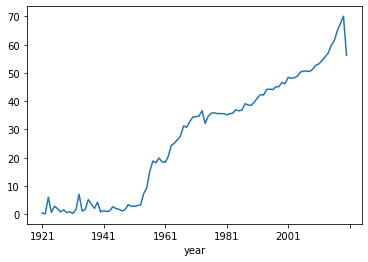

In [126]:
dfz["popularity"].plot()

In [154]:
dfz = pd.read_csv("data_by_year.csv").drop("Unnamed: 0", axis = 1)

In [156]:
dfz["year"] = dfz["year"].astype(int)

In [160]:
dfz[["year", "popularity"]]

,year,popularity
year,841.666667,587.594822
popularity,587.594822,433.882877


In [163]:
dfc = normalize(dfs)
dfc

,acousticness,artists,danceability,duration_min,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.7320,['Dennis Day'],0.819,3,0.3410,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,5,1,Clancy Lowered the Boom,0.0008,1921,0.4150,3,0.9630,1921
1,0.9820,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,14,0.2110,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,4,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",0.0005,1921,0.0366,4,0.0594,1921
2,0.9960,['John McCormack'],0.518,3,0.2030,0,5uNZnElqOS3W4fRmRYPk4T,0.000000,0,0.115,5,1,The Wearing of the Green,0.0006,1921,0.0615,3,0.4060,1921
3,0.9820,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,14,0.2110,0,1SCWBjhk5WmXPxhDduD3HM,0.878000,10,0.665,4,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",0.0004,1921,0.0366,4,0.0594,1921
4,0.9570,['Phil Regan'],0.418,3,0.1930,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,5,1,When Irish Eyes Are Smiling,0.0004,1921,0.0380,5,0.2530,1921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168587,0.6430,['Kelly Clarkson'],0.481,3,0.3680,0,5Y5b0wokJqZxaefDVRm43v,0.000000,7,0.125,5,0,Born to Die,0.0058,2020-03-13,0.0300,7,0.5070,2020
168588,0.6700,['JoJo'],0.661,3,0.5800,1,7wrBKecywD6TUuHQl3wjmj,0.000055,0,0.117,5,1,Man,0.0063,2020-03-13,0.1240,4,0.5660,2020
168589,0.9790,['S.J Morgan'],0.502,3,0.0355,0,67zZV7JzIx9Wcf65Ztt4CJ,0.867000,0,0.106,3,1,Rivers,0.0066,2020-02-28,0.0379,8,0.2820,2020
168590,0.6720,['Childish Gambino'],0.174,3,0.0466,0,4Ksj9mKfsYC5b8v8Ey3c8I,0.196000,3,0.420,4,1,0.00,0.0062,2020-03-22,0.0495,6,0.0337,2020


In [167]:
dfd = dd.from_pandas(dfc, npartitions = 50)

In [168]:
dfd

,acousticness,artists,danceability,duration_min,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
npartitions=50,,,,,,,,,,,,,,,,,,,
0,float64,object,float64,int64,float64,int64,object,float64,int64,float64,int64,int64,object,float64,object,float64,int64,float64,object
3372,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165228,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168591,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
